# Final Project - Part 2
## Problem Statement
My goal with this analysis is to determine if the Vaccine Adverse Event Reporting System (VAERS) data can help predict a patient's outcome given their adverse symptoms or other relevant information from taking a given vaccine.  This will be a binary classification problem where the model's made will determine if the patient DIED (y=1) or LIVED (y=0) from their adverse event report.  
I am solving this problem in order to better understand the severity of adverse reactions people can have from certain vaccines.

# 2. Exploratory Data Analysis (EDA)

**Dataset**: “VAERS Data Sets”


**Dataset Source**: https://vaers.hhs.gov/data/datasets.html



**Key attributes/dimensions of the data**: 
There are 3 main CSV files associated with this dataset:
1)	*VAERSDATA.csv 
2)	*VAERSSYMPTOMS.csv
3)	*VAERSVAX.csv

These CSV files contain numbers, dates, and other unique values that can be mapped to their Vaccine Adverse Event Reporting System (VAERS) identification number for each person among the spreadsheets.  The VAERS was made by the Food and Drug Administration (FDA) and the Centers for Disease Control and Prevention (CDC) to collect data on adverse reactions that could be associated with vaccines in general.  

I pulled this data on 9/6/2024, which stated the data contains VAERS reports processed as of **08/30/2024**.

I filtered to only include those vaccines related to COVID19.  This dataset includes false positives for adverse reactions given a vaccine due to the encouragement towards doctors and other vaccine providers to report any adverse event if seen regardless of if they can prove the vaccine was the cause.  Therefore, the dataset contains a combination of coincidental events and those truly caused by the vaccine.  

The dataset I downloaded I have shared here on my GDRIVE for people to reproduce my work: 

https://drive.google.com/file/d/13ft2QazL4OugjftllcwjPXLUVMB8-2Xi/view?usp=drive_link

In Part 1, I filtered these datasets to only include COVID19 and performed some minor *Data Cleaning*.  I will continue that effort here.

**Import Libraries**

In [1]:
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,  StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")


C:\Users\Steven\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Import Data from Part 1**

In [2]:
df_COVID = pd.read_csv("df_COVID.csv",index_col=None)
df_COVID

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,SYMPTOM5,SYMPTOMVERSION5,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME,DAYS_to_DEATH
0,902418,12/15/2020,NJ,56.0,56.0,NaN,F,NaN,Patient experienced mild numbness traveling fr...,NaN,...,NaN,NaN,COVID19,PFIZER\BIONTECH,EH9899,1,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),NaN
1,902440,12/15/2020,AZ,35.0,35.0,NaN,F,NaN,C/O Headache,NaN,...,NaN,NaN,COVID19,PFIZER\BIONTECH,EH 9899,1,SYR,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),NaN
2,902446,12/15/2020,WV,55.0,55.0,NaN,F,NaN,"felt warm, hot and face and ears were red and ...",NaN,...,NaN,NaN,COVID19,PFIZER\BIONTECH,EH9899,1,IM,RA,COVID19 (COVID19 (PFIZER-BIONTECH)),NaN
3,902464,12/15/2020,LA,42.0,42.0,NaN,M,NaN,within 15 minutes progressive light-headedness...,NaN,...,Presyncope,23.1,COVID19,PFIZER\BIONTECH,EH9899,UNK,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),NaN
4,902465,12/15/2020,AR,60.0,60.0,NaN,F,NaN,Pt felt wave come over body @ 1218 starting in...,NaN,...,Parosmia,23.1,COVID19,PFIZER\BIONTECH,EH9899,1,IM,RA,COVID19 (COVID19 (PFIZER-BIONTECH)),NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910786,2787640,08/29/2024,NM,11.0,11.0,NaN,F,NaN,Moderna COVID vaccine for patients greater tha...,NaN,...,NaN,NaN,COVID19,MODERNA,8062120,5,IM,LA,COVID19 (COVID19 (MODERNA BIVALENT)),NaN
910787,2787643,08/29/2024,OR,67.0,67.0,NaN,F,NaN,Dizziness immediately after vaccine lasting ab...,NaN,...,NaN,NaN,COVID19,PFIZER\BIONTECH,LM2216,1,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),NaN
910788,2787649,08/29/2024,FL,78.0,78.0,NaN,F,NaN,"During a vaccine clinic at her nursing home, t...",NaN,...,NaN,NaN,COVID19,MODERNA,3042914,UNK,IM,RA,COVID19 (COVID19 (MODERNA BIVALENT)),NaN
910789,2787667,08/29/2024,AZ,21.0,21.0,NaN,M,NaN,Sickness for over a week including nausea and ...,NaN,...,NaN,NaN,COVID19,MODERNA,038C21A,1,NaN,RA,COVID19 (COVID19 (MODERNA)),NaN


## 2.1 Data Cleaning

In [3]:
df_COVID.describe()

,VAERS_ID,AGE_YRS,CAGE_YR,CAGE_MO,HOSPDAYS,NUMDAYS,FORM_VERS,SYMPTOMVERSION1,SYMPTOMVERSION2,SYMPTOMVERSION3,SYMPTOMVERSION4,SYMPTOMVERSION5,DAYS_to_DEATH
count,9.107910e+05,809846.000000,709781.000000,4258.000000,49154.000000,778506.000000,910791.000000,910791.000000,743379.000000,573924.000000,432266.000000,324771.000000,14905.000000
mean,1.664290e+06,50.267979,49.882389,0.338633,10.544778,43.859819,1.998932,24.239516,24.241974,24.228382,24.214482,24.226294,154.023818
std,5.330600e+05,19.821425,20.087632,0.330600,639.878373,610.399894,0.032667,0.652729,0.656992,0.647661,0.637458,0.645407,846.582838
min,9.024180e+05,0.080000,0.000000,0.000000,1.000000,0.000000,1.000000,23.100000,23.100000,23.100000,23.100000,23.100000,-36523.000000
25%,1.201110e+06,35.000000,35.000000,0.000000,2.000000,0.000000,2.000000,24.000000,24.000000,24.000000,24.000000,24.000000,13.000000
50%,1.587323e+06,51.000000,51.000000,0.300000,4.000000,1.000000,2.000000,24.000000,24.000000,24.000000,24.000000,24.000000,86.000000
75%,2.075621e+06,66.000000,66.000000,0.600000,7.000000,8.000000,2.000000,24.100000,24.100000,24.100000,24.100000,24.100000,231.000000
max,2.787668e+06,119.000000,120.000000,1.000000,99999.000000,44224.000000,2.000000,27.000000,27.000000,27.000000,27.000000,27.000000,36896.000000


We can see that there are several null-values in the dataset.  Some are obvious like the **DAYS_to_DEATH** because not everyone died.  We can cleanup this a little bit based on some of the features we might want to use later in our feature selection stage.

In [4]:
print(df_COVID.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910791 entries, 0 to 910790
Data columns (total 53 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   VAERS_ID         910791 non-null  int64  
 1   RECVDATE         910791 non-null  object 
 2   STATE            769136 non-null  object 
 3   AGE_YRS          809846 non-null  float64
 4   CAGE_YR          709781 non-null  float64
 5   CAGE_MO          4258 non-null    float64
 6   SEX              910791 non-null  object 
 7   RPT_DATE         902 non-null     object 
 8   SYMPTOM_TEXT     910791 non-null  object 
 9   DIED             17244 non-null   object 
 10  DATEDIED         15226 non-null   object 
 11  L_THREAT         14897 non-null   object 
 12  ER_VISIT         137 non-null     object 
 13  HOSPITAL         79771 non-null   object 
 14  HOSPDAYS         49154 non-null   float64
 15  X_STAY           492 non-null     object 
 16  DISABLE          18058 non-null   obje

In [5]:
#We can assume 'UNKNOWN' for object or str types that we dont know otherwise.
df_COVID['SEX'].fillna('Unknown', inplace=True) 
df_COVID['STATE'].fillna('Unknown', inplace=True)
df_COVID['VAX_LOT'].fillna('Unknown', inplace=True)
df_COVID['VAX_MANU'].fillna('Unknown', inplace=True)
df_COVID['VAX_SITE'].fillna('Unknown', inplace=True)
df_COVID['AGE_YRS'].fillna(df_COVID['AGE_YRS'].median(), inplace=True) #assume that the median age can be imputed for these values
df_COVID['ALLERGIES'].fillna('', inplace=True)  
df_COVID['HISTORY'].fillna('', inplace=True)  
df_COVID['CUR_ILL'].fillna('', inplace=True)  
df_COVID['SYMPTOMS'] = df_COVID[['SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5']].fillna('').apply(lambda x: ' '.join(x), axis=1)
df_COVID.SYMPTOMS = [w.lower() for w in df_COVID.SYMPTOMS]
df_COVID['SYMPTOMS'].fillna('', inplace=True)  
df_COVID['HOSPDAYS'].fillna(0.,inplace=True)

In [6]:
print(df_COVID.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910791 entries, 0 to 910790
Data columns (total 54 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   VAERS_ID         910791 non-null  int64  
 1   RECVDATE         910791 non-null  object 
 2   STATE            910791 non-null  object 
 3   AGE_YRS          910791 non-null  float64
 4   CAGE_YR          709781 non-null  float64
 5   CAGE_MO          4258 non-null    float64
 6   SEX              910791 non-null  object 
 7   RPT_DATE         902 non-null     object 
 8   SYMPTOM_TEXT     910791 non-null  object 
 9   DIED             17244 non-null   object 
 10  DATEDIED         15226 non-null   object 
 11  L_THREAT         14897 non-null   object 
 12  ER_VISIT         137 non-null     object 
 13  HOSPITAL         79771 non-null   object 
 14  HOSPDAYS         910791 non-null  float64
 15  X_STAY           492 non-null     object 
 16  DISABLE          18058 non-null   obje

## 2.2 Data Visualization

In [7]:
# Define features we might want to look at
categorical_features = ['SEX', 'STATE', 'VAX_LOT', 'VAX_MANU', 'VAX_SITE',"HOSPITAL"]
numerical_features = ['AGE_YRS',"HOSPDAYS"]
text_feature_allergies = 'ALLERGIES'
text_feature_HISTORY = 'HISTORY'
text_feature_CUR_ILL = "CUR_ILL"
text_feature_symptoms = 'SYMPTOMS'  




df_COVID['HOSPITAL'] = df_COVID['HOSPITAL'].apply(lambda x: 1 if pd.notnull(x) else 0)

df_COVID['DIED'] = df_COVID['DIED'].apply(lambda x: 1 if pd.notnull(x) else 0)

In [8]:
df_COVID[numerical_features+["DIED"]].corr().reset_index().melt('index')

,index,variable,value
0,AGE_YRS,AGE_YRS,1.000000
1,HOSPDAYS,AGE_YRS,0.003181
2,DIED,AGE_YRS,0.154165
3,AGE_YRS,HOSPDAYS,0.003181
4,HOSPDAYS,HOSPDAYS,1.000000
5,DIED,HOSPDAYS,0.002571
6,AGE_YRS,DIED,0.154165
7,HOSPDAYS,DIED,0.002571
8,DIED,DIED,1.000000


In [9]:
df_COVID[numerical_features+["DIED"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910791 entries, 0 to 910790
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   AGE_YRS   910791 non-null  float64
 1   HOSPDAYS  910791 non-null  float64
 2   DIED      910791 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 20.8 MB


In [10]:
df_COVID.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910791 entries, 0 to 910790
Data columns (total 54 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   VAERS_ID         910791 non-null  int64  
 1   RECVDATE         910791 non-null  object 
 2   STATE            910791 non-null  object 
 3   AGE_YRS          910791 non-null  float64
 4   CAGE_YR          709781 non-null  float64
 5   CAGE_MO          4258 non-null    float64
 6   SEX              910791 non-null  object 
 7   RPT_DATE         902 non-null     object 
 8   SYMPTOM_TEXT     910791 non-null  object 
 9   DIED             910791 non-null  int64  
 10  DATEDIED         15226 non-null   object 
 11  L_THREAT         14897 non-null   object 
 12  ER_VISIT         137 non-null     object 
 13  HOSPITAL         910791 non-null  int64  
 14  HOSPDAYS         910791 non-null  float64
 15  X_STAY           492 non-null     object 
 16  DISABLE          18058 non-null   obje

We can visualize if any of the words are highly correlated with the patient dieing using TFID

**SYMPTOMS**

In [11]:
KEYWORD = "SYMPTOMS"
df_COVID[KEYWORD] = df_COVID[KEYWORD].astype(str)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100) 
tfidf_matrix = tfidf_vectorizer.fit_transform(df_COVID[KEYWORD])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df['DIED'] = df_COVID['DIED'].copy()
correlation_matrix = tfidf_df.corr()
correlation_with_died = correlation_matrix['DIED'].drop('DIED').sort_values(ascending=False)
print(f"Top 20 postive correlated words from {KEYWORD}")
print(correlation_with_died.head(20))
print(f"Top 20 negative correlated words from {KEYWORD}")
print(correlation_with_died.tail(20))
correlation_data = correlation_with_died.reset_index()
correlation_data.columns = ['word', 'correlation']

heatmap = alt.Chart(correlation_data).mark_rect().encode(
    x=alt.X('word:N', title='Word', sort=None),
    y=alt.Y('correlation:Q', title='Correlation with DIED'),
    color=alt.Color('correlation:Q', scale=alt.Scale(scheme='redblue')),
    tooltip=[alt.Tooltip('word:N', title='Word'), alt.Tooltip('correlation:Q', title='Correlation')]
).properties(
    title=f'Correlation Between TF-IDF Words {KEYWORD} and Death (DIED)',
    width=2000,
    height=300
)

heatmap

Top 20 postive correlated words from SYMPTOMS
death           0.795151
acute           0.136101
19              0.123848
covid           0.123820
respiratory     0.120153
cardiac         0.097695
failure         0.090325
positive        0.054829
dyspnoea        0.026320
sars            0.024627
cov             0.024626
ray             0.021438
aggravated      0.016143
condition       0.016004
asthenia        0.014294
abnormal        0.013698
infection       0.012394
tomogram        0.009290
computerised    0.009279
test            0.006481
Name: DIED, dtype: float64
Top 20 negative correlated words from SYMPTOMS
feeling        -0.024540
discomfort     -0.024912
myalgia        -0.026486
nausea         -0.027781
arthralgia     -0.029481
extremity      -0.030806
pruritus       -0.031124
rash           -0.031540
pyrexia        -0.031992
erythema       -0.032097
swelling       -0.032302
dizziness      -0.035036
administered   -0.035852
product        -0.037321
chills         -0.040998
fatig

alt.Chart(...)

That is a significant **leakage** word, *death*.  We will remove it later to prevent data leakage.

**HISTORY**

In [12]:
KEYWORD = "HISTORY"
df_COVID[KEYWORD] = df_COVID[KEYWORD].astype(str)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100) 
tfidf_matrix = tfidf_vectorizer.fit_transform(df_COVID[KEYWORD])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df['DIED'] = df_COVID['DIED'].copy()
correlation_matrix = tfidf_df.corr()
correlation_with_died = correlation_matrix['DIED'].drop('DIED').sort_values(ascending=False)
print(f"Top 20 postive correlated words from {KEYWORD}")
print(correlation_with_died.head(20))
print(f"Top 20 negative correlated words from {KEYWORD}")
print(correlation_with_died.tail(20))
correlation_data = correlation_with_died.reset_index()
correlation_data.columns = ['word', 'correlation']

heatmap = alt.Chart(correlation_data).mark_rect().encode(
    x=alt.X('word:N', title='Word', sort=None),
    y=alt.Y('correlation:Q', title='Correlation with DIED'),
    color=alt.Color('correlation:Q', scale=alt.Scale(scheme='redblue')),
    tooltip=[alt.Tooltip('word:N', title='Word'), alt.Tooltip('correlation:Q', title='Correlation')]
).properties(
    title=f'Correlation Between TF-IDF Words {KEYWORD} and Death (DIED)',
    width=2000,
    height=300
)

heatmap

Top 20 postive correlated words from HISTORY
failure           0.091570
htn               0.078724
cad               0.073180
copd              0.067407
stage             0.060421
dm                0.053836
fibrillation      0.051160
hyperlipidemia    0.045558
atrial            0.045485
artery            0.043895
disease           0.043422
coronary          0.041837
mellitus          0.040119
chronic           0.039813
pulmonary         0.038694
kidney            0.036596
lung              0.036535
heart             0.036499
acute             0.035756
unspecified       0.034841
Name: DIED, dtype: float64
Top 20 negative correlated words from HISTORY
seasonal      -0.009162
penicillin    -0.009682
cholesterol   -0.009744
provided      -0.010197
reporter      -0.010244
blood         -0.010614
pressure      -0.010659
comments      -0.012057
migraines     -0.012117
list          -0.012750
high          -0.013140
encoded       -0.014287
relevant      -0.014685
allergies     -0.016556
allerg

alt.Chart(...)

**CUR_ILL**

In [13]:
KEYWORD = "CUR_ILL"
df_COVID[KEYWORD] = df_COVID[KEYWORD].astype(str)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100) 
tfidf_matrix = tfidf_vectorizer.fit_transform(df_COVID[KEYWORD])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df['DIED'] = df_COVID['DIED'].copy()
correlation_matrix = tfidf_df.corr()
correlation_with_died = correlation_matrix['DIED'].drop('DIED').sort_values(ascending=False)
print(f"Top 20 postive correlated words from {KEYWORD}")
print(correlation_with_died.head(20))
print(f"Top 20 negative correlated words from {KEYWORD}")
print(correlation_with_died.tail(20))
correlation_data = correlation_with_died.reset_index()
correlation_data.columns = ['word', 'correlation']

heatmap = alt.Chart(correlation_data).mark_rect().encode(
    x=alt.X('word:N', title='Word', sort=None),
    y=alt.Y('correlation:Q', title='Correlation with DIED'),
    color=alt.Color('correlation:Q', scale=alt.Scale(scheme='redblue')),
    tooltip=[alt.Tooltip('word:N', title='Word'), alt.Tooltip('correlation:Q', title='Correlation')]
).properties(
    title=f'Correlation Between TF-IDF Words {KEYWORD} and Death (DIED)',
    width=2000,
    height=300
)

heatmap

Top 20 postive correlated words from CUR_ILL
failure           0.055522
unknown           0.046462
acute             0.027771
copd              0.026432
htn               0.023271
heart             0.022184
chronic           0.021401
hyperlipidemia    0.019530
anemia            0.016397
21                0.016300
kidney            0.016267
disease           0.015299
uti               0.013749
19                0.013511
type              0.013202
diabetes          0.012870
cancer            0.012790
unspecified       0.012514
hypertension      0.011930
2021              0.011821
Name: DIED, dtype: float64
Top 20 negative correlated words from CUR_ILL
arthritis      -0.003038
alcohol        -0.003272
years          -0.003547
allergic       -0.003739
fibromyalgia   -0.003889
verbatim       -0.003979
cholesterol    -0.003984
migraine       -0.004095
abstains       -0.004148
na             -0.004320
penicillin     -0.004353
denies         -0.004615
sinus          -0.005068
asthma         -0

alt.Chart(...)

**ALLERGIES**

In [14]:
KEYWORD = "ALLERGIES"
df_COVID[KEYWORD] = df_COVID[KEYWORD].astype(str)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100) 
tfidf_matrix = tfidf_vectorizer.fit_transform(df_COVID[KEYWORD])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df['DIED'] = df_COVID['DIED'].copy()
correlation_matrix = tfidf_df.corr()
correlation_with_died = correlation_matrix['DIED'].drop('DIED').sort_values(ascending=False)
print(f"Top 20 postive correlated words from {KEYWORD}")
print(correlation_with_died.head(20))
print(f"Top 20 negative correlated words from {KEYWORD}")
print(correlation_with_died.tail(20))
correlation_data = correlation_with_died.reset_index()
correlation_data.columns = ['word', 'correlation']

heatmap = alt.Chart(correlation_data).mark_rect().encode(
    x=alt.X('word:N', title='Word', sort=None),
    y=alt.Y('correlation:Q', title='Correlation with DIED'),
    color=alt.Color('correlation:Q', scale=alt.Scale(scheme='redblue')),
    tooltip=[alt.Tooltip('word:N', title='Word'), alt.Tooltip('correlation:Q', title='Correlation')]
).properties(
    title=f'Correlation Between TF-IDF Words {KEYWORD} and Death (DIED)',
    width=2000,
    height=300
)

heatmap

Top 20 postive correlated words from ALLERGIES
unknown        0.050929
penicillins    0.017033
known          0.014771
nkda           0.014419
nka            0.014084
lisinopril     0.011092
allergies      0.010466
reaction       0.008065
reported       0.006995
oxycodone      0.006622
nausea         0.005335
swelling       0.004784
cephalexin     0.004664
itching        0.003392
vomiting       0.003227
tramadol       0.003173
codeine        0.002976
drug           0.002706
rash           0.002389
adhesive       0.002084
Name: DIED, dtype: float64
Top 20 negative correlated words from ALLERGIES
peanuts       -0.005591
wheat         -0.005973
cats          -0.006095
sensitivity   -0.006320
pollen        -0.006436
dust          -0.006604
nuts          -0.006723
tree          -0.006788
mold          -0.007062
dairy         -0.007530
shellfish     -0.007712
seasonal      -0.008203
amoxicillin   -0.008476
drugs         -0.008746
gluten        -0.009182
allergic      -0.009233
allergy       

alt.Chart(...)

In [15]:
KEYWORD = "SYMPTOM_TEXT"
df_COVID[KEYWORD] = df_COVID[KEYWORD].astype(str)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100) 
tfidf_matrix = tfidf_vectorizer.fit_transform(df_COVID[KEYWORD])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df['DIED'] = df_COVID['DIED'].copy()
correlation_matrix = tfidf_df.corr()
correlation_with_died = correlation_matrix['DIED'].drop('DIED').sort_values(ascending=False)
print(f"Top 20 postive correlated words from {KEYWORD}")
print(correlation_with_died.head(20))
print(f"Top 20 negative correlated words from {KEYWORD}")
print(correlation_with_died.tail(20))
correlation_data = correlation_with_died.reset_index()
correlation_data.columns = ['word', 'correlation']

heatmap = alt.Chart(correlation_data).mark_rect().encode(
    x=alt.X('word:N', title='Word', sort=None),
    y=alt.Y('correlation:Q', title='Correlation with DIED'),
    color=alt.Color('correlation:Q', scale=alt.Scale(scheme='redblue')),
    tooltip=[alt.Tooltip('word:N', title='Word'), alt.Tooltip('correlation:Q', title='Correlation')]
).properties(
    title=f'Correlation Between TF-IDF Words {KEYWORD} and Death (DIED)',
    width=2000,
    height=300
)

heatmap

Top 20 postive correlated words from SYMPTOM_TEXT
positive       0.099745
covid          0.099335
21             0.097907
2021           0.088186
patient        0.044969
2022           0.044568
12             0.036367
10             0.028637
medical        0.024266
19             0.021304
event          0.013414
prior          0.011748
case           0.011662
reported       0.008590
date           0.005771
blood          0.005705
unspecified    0.002359
30             0.001998
time           0.001036
pfizer        -0.001089
Name: DIED, dtype: float64
Top 20 negative correlated words from SYMPTOM_TEXT
dosage        -0.032351
sore          -0.032480
dose          -0.032988
experienced   -0.033309
rash          -0.033761
left          -0.034168
included      -0.034440
1273          -0.034684
describes     -0.035276
occurrence    -0.035415
body          -0.035700
chills        -0.037103
concomitant   -0.037397
mrna          -0.038153
outcome       -0.039827
pain          -0.042031
site    

alt.Chart(...)

                 VAX_LOT_encoded  SEX_encoded      DIED
VAX_LOT_encoded         1.000000     0.073659 -0.018087
SEX_encoded             0.073659     1.000000  0.065482
DIED                   -0.018087     0.065482  1.000000


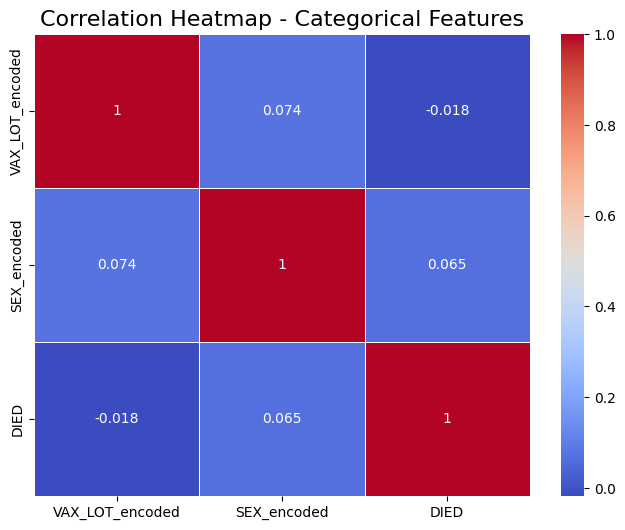

In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

df_COVID['VAX_LOT_encoded'] = label_encoder.fit_transform(df_COVID['VAX_LOT'])
df_COVID['SEX_encoded'] = label_encoder.fit_transform(df_COVID['SEX'])
correlation_matrix = df_COVID[['VAX_LOT_encoded', 'SEX_encoded','DIED']].corr()

print(correlation_matrix)

corr_matrix = correlation_matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap - Categorical Features', fontsize=16)
plt.show()

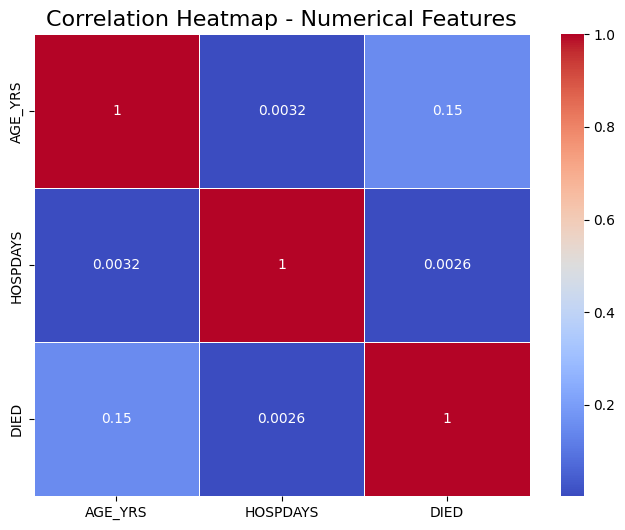

In [17]:
corr_matrix = df_COVID[numerical_features+["DIED"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap - Numerical Features', fontsize=16)
plt.show()

Look for data leakage by keywords in the **SYMPTOMS** that might indicate they died like *death*.  

In [18]:
df_COVID[(df_COVID.SYMPTOMS.str.contains("death")) & (df_COVID.DIED==1)] #Does include 'death' 

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME,DAYS_to_DEATH,SYMPTOMS,VAX_LOT_encoded,SEX_encoded
5083,910363,12/28/2020,CA,84.0,84.0,NaN,M,NaN,"Patient had mild hypotension, decreased oral i...",1,...,MODERNA,LOT 039K20A,1,IM,RA,COVID19 (COVID19 (MODERNA)),5.0,death hypophagia hypotension somnolence,33560,1
7214,913143,12/29/2020,TX,84.0,84.0,NaN,F,NaN,Vaccine administered with no immediate adverse...,1,...,PFIZER\BIONTECH,EL0140,1,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),0.0,death,24333,0
7697,913733,12/30/2020,PA,85.0,85.0,NaN,F,NaN,My grandmother died a few hours after receivin...,1,...,Unknown,Unknown,UNK,NaN,Unknown,COVID19 (COVID19 (MODERNA)),0.0,death,36872,0
8436,914604,12/30/2020,MI,74.0,74.0,NaN,M,NaN,Spouse awoke 12/20 and found spouse dead. Clie...,1,...,PFIZER\BIONTECH,EH9899,1,IM,Unknown,COVID19 (COVID19 (PFIZER-BIONTECH)),4.0,death,23745,1
8450,914621,12/30/2020,IA,89.0,89.0,NaN,F,NaN,Resident in our long term care facility who re...,1,...,MODERNA,011J02A,1,IM,RA,COVID19 (COVID19 (MODERNA)),5.0,death dementia fatigue,3010,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910579,2785362,08/19/2024,MO,68.0,68.0,NaN,F,NaN,Turbo Cancer rapidly spread throughout her bod...,1,...,MODERNA,033F21A,3,SYR,RA,COVID19 (COVID19 (MODERNA)),945.0,death metastases to central nervous system met...,9278,0
910598,2785541,08/20/2024,MS,82.0,82.0,NaN,M,NaN,Reported Symptoms: 10011906:DEATH; Narrative:...,1,...,MODERNA,039K20A,1,IM,RA,COVID19 (COVID19 (MODERNA)),10.0,cardiac failure congestive confusional state d...,10425,1
910651,2786159,08/22/2024,MN,65.0,65.0,NaN,F,NaN,Patient expired 8/21/2024.,1,...,MODERNA,031A21A,1,IM,LA,COVID19 (COVID19 (MODERNA)),138.0,death,8546,0
910661,2786281,08/22/2024,TX,81.0,NaN,NaN,F,NaN,death; shortness of breath; Nausea; vomiting; ...,1,...,Unknown,Unknown,1,NaN,RA,COVID19 (COVID19 (PFIZER-BIONTECH)),NaN,death dyspnoea nausea vomiting,36872,0


In [19]:
list(df_COVID[(df_COVID.SYMPTOMS.str.lower().str.contains("death")) & (df_COVID.DIED==1)].SYMPTOMS)[0:20]

['death hypophagia hypotension somnolence ',
 'death    ',
 'death    ',
 'death    ',
 'death dementia fatigue  ',
 'anxiety death pyrexia respiratory distress sars-cov-2 test negative',
 'death    ',
 'death    ',
 'death myocardial infarction   ',
 'death    ',
 'death    ',
 'death dyspnoea vomiting  ',
 'cardiac arrest death unresponsive to stimuli  ',
 'death    ',
 'death    ',
 'covid-19 death sars-cov-2 test positive  ',
 'covid-19 death exposure to sars-cov-2 sars-cov-2 test positive ',
 'covid-19 death sars-cov-2 test positive  ',
 'death unresponsive to stimuli   ',
 'death pulse absent respiratory arrest resuscitation unresponsive to stimuli']

In [20]:
df_COVID[(~df_COVID.SYMPTOMS.str.contains("death")) & (df_COVID.DIED==1)] #Does NOT include 'death' 

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME,DAYS_to_DEATH,SYMPTOMS,VAX_LOT_encoded,SEX_encoded
4110,909095,12/25/2020,CO,66.0,66.0,NaN,M,NaN,on 12/24/2020 the resident was sleepy and stay...,1,...,MODERNA,011J20A,1,IM,RA,COVID19 (COVID19 (MODERNA)),2.0,foaming at mouth pain in extremity pallor puls...,3031,1
11660,918418,01/04/2021,FL,65.0,65.0,NaN,M,NaN,"Resident became SOB, congested and hypoxic req...",1,...,PFIZER\BIONTECH,EL0140,1,IM,RA,COVID19 (COVID19 (PFIZER-BIONTECH)),4.0,dyspnoea hospice care hypoxia oxygen saturatio...,24333,1
12170,919108,01/04/2021,NY,100.0,100.0,NaN,F,NaN,"Fever, Malaise",1,...,PFIZER\BIONTECH,F10140,UNK,IM,Unknown,COVID19 (COVID19 (PFIZER-BIONTECH)),12.0,blood culture culture urine full blood count m...,29032,0
12528,919537,01/04/2021,MN,96.0,96.0,NaN,F,NaN,Resident exhibited no adverse events during 30...,1,...,MODERNA,026L20A,1,IM,RA,COVID19 (COVID19 (MODERNA)),0.0,pulse absent,6862,0
13212,920368,01/05/2021,IN,92.0,92.0,NaN,F,NaN,12/30/2020 07:02 AM Resident noted to have so...,1,...,MODERNA,026L20A,1,IM,RA,COVID19 (COVID19 (MODERNA)),3.0,blood creatinine increased blood urea increase...,6862,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910153,2781549,07/26/2024,FL,91.0,91.0,NaN,M,NaN,Reported Symptoms: 10011906:DEATH; 10057678:...,1,...,MODERNA,065F21A,3,IM,RA,COVID19 (COVID19 (MODERNA BIVALENT)),0.0,disease complication vascular dementia,13903,1
910198,2781731,07/29/2024,GA,78.0,78.0,NaN,F,NaN,Resident had a heart attack in the dining room...,1,...,MODERNA,206E23-2A,6,IM,LA,COVID19 (COVID19 (MODERNA)),4.0,myocardial infarction posture abnormal,17263,0
910276,2782225,07/31/2024,TN,77.0,77.0,NaN,M,NaN,Covid-19 breakthrough infection,1,...,MODERNA,004M20A,2,NaN,Unknown,COVID19 (COVID19 (MODERNA)),833.0,breakthrough covid-19,1458,1
910297,2782378,08/01/2024,MI,55.0,55.0,NaN,M,NaN,Lung Cancer,1,...,Unknown,Unknown,1,NaN,Unknown,COVID19 (COVID19 (MODERNA)),1139.0,biopsy lung neoplasm malignant,36872,1


In [21]:
list(df_COVID[(~df_COVID.SYMPTOMS.str.lower().str.contains("death")) & (df_COVID.DIED==1)].SYMPTOMS)[0:20]

['foaming at mouth pain in extremity pallor pulse absent respiratory arrest',
 'dyspnoea hospice care hypoxia oxygen saturation decreased pulse absent',
 'blood culture culture urine full blood count malaise pyrexia',
 'pulse absent    ',
 'blood creatinine increased blood urea increased body temperature increased chest x-ray abnormal decreased appetite',
 'abnormal behaviour blood pressure abnormal fatigue limb discomfort pulse absent',
 'body temperature increased dyspnoea   ',
 'pyrexia respiratory depression sars-cov-2 test positive  ',
 'pupil fixed regurgitation respiratory arrest sars-cov-2 test positive unresponsive to stimuli',
 'cardiac arrest condition aggravated haemoptysis lung neoplasm malignant ',
 'chest pain dyspnoea myocardial infarction pyrexia ',
 'myocardial infarction    ',
 'palpitations syncope   ',
 'asymptomatic covid-19 sars-cov-2 test positive   ',
 'body temperature increased complication associated with device cough dyspnoea hypoxia',
 'cardiac arrest card

In [22]:
list(df_COVID[df_COVID.SYMPTOMS.str.contains("autopsy")].SYMPTOMS)[0:20] #Another leaky word, 'autopsy'

['autopsy cardio-respiratory arrest death resuscitation syncope',
 'autopsy death   ',
 'autopsy blood test culture tissue specimen death toxicologic test',
 'autopsy cardiac arrest death pulse absent respiratory arrest',
 'autopsy death syncope  ',
 'autopsy death maternal exposure during breast feeding  ',
 'autopsy sudden death   ',
 'autopsy death malaise  ',
 'alanine aminotransferase normal aspartate aminotransferase increased autopsy bilirubin conjugated increased blood alkaline phosphatase increased',
 'asthenia autopsy cardiac arrest death fatigue',
 'autopsy cardiac arrest cardio-respiratory arrest chest x-ray abnormal cyanosis',
 'autopsy cyanosis death dental discomfort diarrhoea haemorrhagic',
 'autopsy cardio-respiratory arrest death  ',
 'autopsy death   ',
 'autopsy death   ',
 'autopsy bone fragmentation computerised tomogram abnormal computerised tomogram spine death',
 'autopsy death   ',
 'autopsy coronary artery thrombosis sudden cardiac death  ',
 'arteriosclerosi

We will cleanup the data some more so that we don't leak the truth into the training features.  We will remove rows with SYMPTOMS containing 'death' and 'autopsy'.  

In [23]:
df_COVID = df_COVID[(~df_COVID.SYMPTOMS.str.contains("death")) & (~df_COVID.SYMPTOMS.str.contains("autopsy"))].reset_index().drop("index",axis=1)
df_COVID

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME,DAYS_to_DEATH,SYMPTOMS,VAX_LOT_encoded,SEX_encoded
0,902418,12/15/2020,NJ,56.0,56.0,NaN,F,NaN,Patient experienced mild numbness traveling fr...,0,...,PFIZER\BIONTECH,EH9899,1,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),NaN,hypoaesthesia injection site hypoaesthesia,23745,0
1,902440,12/15/2020,AZ,35.0,35.0,NaN,F,NaN,C/O Headache,0,...,PFIZER\BIONTECH,EH 9899,1,SYR,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),NaN,headache,23669,0
2,902446,12/15/2020,WV,55.0,55.0,NaN,F,NaN,"felt warm, hot and face and ears were red and ...",0,...,PFIZER\BIONTECH,EH9899,1,IM,RA,COVID19 (COVID19 (PFIZER-BIONTECH)),NaN,erythema feeling hot flushing,23745,0
3,902464,12/15/2020,LA,42.0,42.0,NaN,M,NaN,within 15 minutes progressive light-headedness...,0,...,PFIZER\BIONTECH,EH9899,UNK,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),NaN,dizziness electrocardiogram normal hyperhidros...,23745,1
4,902465,12/15/2020,AR,60.0,60.0,NaN,F,NaN,Pt felt wave come over body @ 1218 starting in...,0,...,PFIZER\BIONTECH,EH9899,1,IM,RA,COVID19 (COVID19 (PFIZER-BIONTECH)),NaN,dysgeusia oral pruritus paraesthesia paraesthe...,23745,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897838,2787640,08/29/2024,NM,11.0,11.0,NaN,F,NaN,Moderna COVID vaccine for patients greater tha...,0,...,MODERNA,8062120,5,IM,LA,COVID19 (COVID19 (MODERNA BIVALENT)),NaN,product administered to patient of inappropria...,20544,0
897839,2787643,08/29/2024,OR,67.0,67.0,NaN,F,NaN,Dizziness immediately after vaccine lasting ab...,0,...,PFIZER\BIONTECH,LM2216,1,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH)),NaN,dizziness tremor,33522,0
897840,2787649,08/29/2024,FL,78.0,78.0,NaN,F,NaN,"During a vaccine clinic at her nursing home, t...",0,...,MODERNA,3042914,UNK,IM,RA,COVID19 (COVID19 (MODERNA BIVALENT)),NaN,dyspepsia feeling abnormal throat irritation,18571,0
897841,2787667,08/29/2024,AZ,21.0,21.0,NaN,M,NaN,Sickness for over a week including nausea and ...,0,...,MODERNA,038C21A,1,NaN,RA,COVID19 (COVID19 (MODERNA)),NaN,illness nausea vomiting,10118,1


## 2.3 Key Insights

It appears that a good chunk of the symptoms contain the word 'covid', which indicates a lot of these people who received the vaccine still got 'covid'.

In [24]:
print(len(list(df_COVID[df_COVID.SYMPTOMS.str.contains("covid")].SYMPTOMS)))

80871


In [25]:
list(df_COVID[df_COVID.SYMPTOMS.str.contains("covid")].SYMPTOMS)[0:20]

['ageusia anosmia body temperature increased covid-19 chills',
 'covid-19 dyspnoea hospice care pyrexia sars-cov-2 test positive',
 'covid-19 decreased appetite fatigue headache myalgia',
 'covid-19 cough headache hyperhidrosis oropharyngeal pain',
 'arthralgia blood test normal body temperature increased bradycardia covid-19 pneumonia',
 'covid-19 lip swelling paraesthesia oral pruritus ',
 'covid-19 chest x-ray abnormal exposure to sars-cov-2 pneumonia ',
 'covid-19 chills laboratory test pain pneumonia',
 'arthralgia covid-19 dizziness loss of consciousness occupational exposure to sars-cov-2',
 'covid-19 impaired work ability pain in extremity pyrexia sars-cov-2 test positive',
 'covid-19 sars-cov-2 test positive   ',
 'covid-19 sars-cov-2 test positive   ',
 'asymptomatic covid-19 sars-cov-2 test positive   ',
 'covid-19 nasal discomfort oropharyngeal pain sars-cov-2 test throat irritation',
 'covid-19 sars-cov-2 test positive unevaluable event  ',
 'covid-19 sars-cov-2 test posit

In fact, it appears that a significant amount of them even died with COVID.

In [26]:
print(len(list(df_COVID[(df_COVID.SYMPTOMS.str.contains("covid")) & (df_COVID.DIED==1)].SYMPTOMS)))

1912


In [27]:
list(df_COVID[(df_COVID.SYMPTOMS.str.contains("covid")) & (df_COVID.DIED==1)].SYMPTOMS)[0:20]

['asymptomatic covid-19 sars-cov-2 test positive   ',
 'asymptomatic covid-19    ',
 'angiogram pulmonary abnormal covid-19 pneumonia cardiomyopathy cardioversion central venous catheterisation',
 'covid-19 decreased appetite dyspnoea fluid intake reduced hypophagia',
 'covid-19 full blood count hyponatraemia metabolic function test ',
 'acute kidney injury acute myocardial infarction acute respiratory distress syndrome covid-19 pneumonia cardiac failure acute',
 'acute respiratory failure ageusia anosmia asthenia covid-19 pneumonia',
 'blood albumin decreased blood creatinine increased blood thyroid stimulating hormone normal blood urea increased covid-19',
 'covid-19 condition aggravated general physical health deterioration lethargy sars-cov-2 test positive',
 'asthenia covid-19 dyspnoea nausea sars-cov-2 test positive',
 'blood pressure increased covid-19 heart rate increased renal failure sars-cov-2 test positive',
 'covid-19 sars-cov-2 test positive   ',
 'covid-19 drug ineffecti

Of the people that died, there was still a good amount of them that died without COVID and was correlated with the vaccine.

In [28]:
print(len(list(df_COVID[(~df_COVID.SYMPTOMS.str.contains("covid")) & (df_COVID.DIED==1)].SYMPTOMS)))

2729


In [29]:
list(df_COVID[(~df_COVID.SYMPTOMS.str.contains("covid")) & (df_COVID.DIED==1)].SYMPTOM_TEXT)[0:20]

['on 12/24/2020 the resident was sleepy and stayed in bed most of the shift.  He stated he was doing okay but requested pain medication for his legs at 250PM.  At 255AM on 12/25/2020 the resident was observed in bed lying still, pale, eyes half open and foam coming from mouth and unresponsive.  He was not breathing and with no pulse',
 'Resident became SOB, congested and hypoxic requiring oxygen, respiratory treatments and suctioning.  Stabilized after treatment and for the next 72 hours with oxygen saturations in the 90s.  On 1/3/2021 was found without pulse and respirations.  Resident was a DNR on Hospice.',
 'Fever, Malaise',
 'Resident exhibited no adverse events during 30 minute monitoring following vaccine administration. Resident found without pulse at 1900.',
 '12/30/2020 07:02 AM  Resident noted to have some redness in face and respiration were fast. Resident vital signs were abnormal except blood pressure. Temp at the time was 102.0 F taken temporal. Resident respirations wer

# 3. Analysis - Model Building/Training

## 3.1 Feature Selection/Engineering

We can use the numerical features, categorical features, and the other text based features we analyzed above to be part of our preprocessing step for training a model.  

Recall that we used Feature Engineering for our **SYMPTOMS** feature, where we combined SYMPTOMS1,2,3,4, and 5.

In [30]:

categorical_features = ['SEX', 'STATE','VAX_LOT', 'VAX_MANU', 'VAX_SITE', 'HOSPITAL']
numerical_features = ['AGE_YRS', 'HOSPDAYS']
text_features = ['ALLERGIES', 'HISTORY', 'CUR_ILL', 'SYMPTOMS']


tfidf_allergies = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_history = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_currill = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_symptoms = TfidfVectorizer(max_features=100, stop_words='english')



preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),  
        ('tfidf_allergies', tfidf_allergies, 'ALLERGIES'),  
        ('tfidf_history', tfidf_history, 'HISTORY'),
        ('tfidf_currill', tfidf_currill, 'CUR_ILL'),
        ('tfidf_symptoms', tfidf_symptoms, 'SYMPTOMS')
    ]
)


# 3.2 Model Building/Training

I will try building 3 different models:
1) **LogisticRegression**
2) **RandomForestClassifier**
3) **XGBClassifier**

In [31]:
models = {
    'LogisticRegression': LogisticRegression(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42),

}

I will use train/test split of 80:20 after shuffling the data

In [32]:
df_COVID = df_COVID.sample(frac=1).reset_index().drop("index",axis=1)

In [33]:
X = df_COVID[categorical_features + numerical_features + text_features]
y = df_COVID['DIED']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
number_died = df_COVID[df_COVID["DIED"]==1].DIED.count()
print("The number of people who DIED: \t",int(number_died))

The number of people who DIED: 	 4641


In [51]:
number_survived = df_COVID[df_COVID["DIED"]!=1].DIED.count()
print("The number of people who SURVIVED: \t",int(number_survived))

The number of people who SURVIVED: 	 893202


In [53]:
class_imbalance = float(number_died/number_survived)
print("The ratio of DIED to Survive (i.e. class imbalance) = ", class_imbalance)

The ratio of DIED to Survive (i.e. class imbalance) =  0.0051959131305124705


We can see that our y_train & y_test are still similarily imbalanced

In [61]:
ratio_y_train = float(y_train.sum()/(y_train[y_train==0].count()))
ratio_y_test = float(y_test.sum()/(y_test[y_test==0].count()))
print("ratio for y_train",ratio_y_train)
print("ratio for y_test",ratio_y_test)

ratio for y_train 0.005165250222857247
ratio for y_test 0.005318583129454314


We can see that we have class imbalance in our data, which makes training models with highly imbalanced data produce models where their accuracy metric is not as insightful since they likely would be high due the imbalance.  
We would rather our model inform us based on the patient's symptoms that they could die than not, so *False Positives* for dieing is not as big of an issue as *False Negatives* for dieing.  The metric that is more meaningful is the *F1-Score* since it is the harmonic mean of *Precision* and *Recall*.  

The *Recall* is a very important metric because it ensures the model's don't miss people who could die based on their symptoms.  
A low *Recall* value would mean that the model misses several people who actually would die.  On the otherhand, a high *Recall* would indicate that the model doesn't miss people who could die.

The *Precision* would indicate how accurate the model is at predicting the right class.    
So if we had a model with low *Precision* and high *Recall*, we would have a model that generates a lot of *False Positives* for people dieing based on their symptoms, but as I mentioned above this isn't as big of an issue as missing them.  
And if we had a model with high *Precision* and high *Recall* we would have a model that generates low *False Positives* and is more accurate on a per class basis.

Therefore, the *F1-Score* is a good metric to use to find the best model since it is a balance of the two.  

Training model: LogisticRegression
Accuracy for LogisticRegression: 0.995
Metrics for LogisticRegression:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    178619
           1       0.66      0.07      0.13       950

    accuracy                           0.99    179569
   macro avg       0.83      0.54      0.56    179569
weighted avg       0.99      0.99      0.99    179569



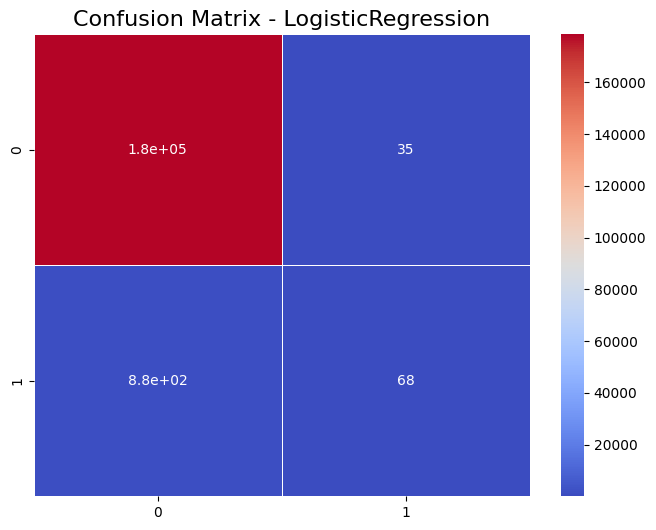

Training model: RandomForest
Accuracy for RandomForest: 0.995
Metrics for RandomForest:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    178619
           1       0.56      0.02      0.04       950

    accuracy                           0.99    179569
   macro avg       0.78      0.51      0.52    179569
weighted avg       0.99      0.99      0.99    179569



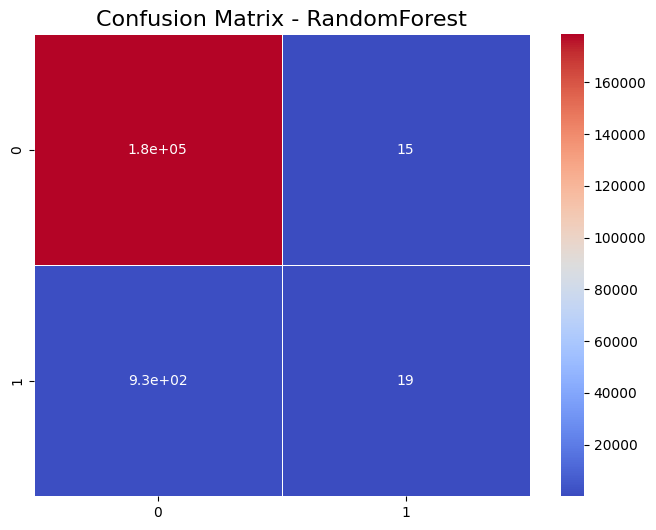

Training model: XGBoost
Accuracy for XGBoost: 0.995
Metrics for XGBoost:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    178619
           1       0.74      0.17      0.27       950

    accuracy                           1.00    179569
   macro avg       0.87      0.58      0.64    179569
weighted avg       0.99      1.00      0.99    179569



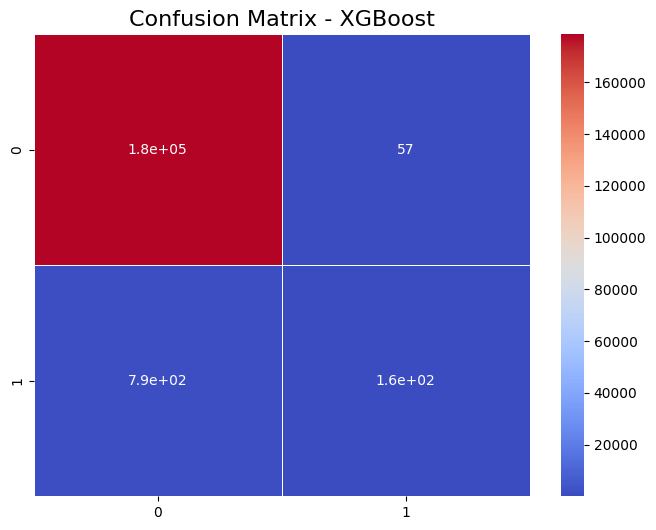

In [67]:
for model_name, model in models.items():
    print(f"Training model: {model_name}")
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy_i = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {model_name}: {round(accuracy_i,3)}")
    classification_report_i = classification_report(y_test, y_pred)
    print(f"Metrics for {model_name}:\n",classification_report_i)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16)
    plt.show()




The model's above really struggle to predict the **DIED** class, hence their *Recall* values are low because of the *False Negatives* for the **DIED** class and *False Positives* for the *Survived** class.  

Our best model appears to be the **XGBoostClassifier** based on its *Accuracy*, *Precision*, *Recall*, and *F1-Score*

To address the class imbalance, we can modify the parameter, **scale_pos_weight** based on the ratio of *CLASS 1 (DIED)* to *CLASS 0 (NOT DIED)*

We can also use a GridSearch of possible values for **scale_pos_weight** to see which performs best.  

In [38]:
param_grid = {
    'classifier__scale_pos_weight': [1, 2, 5, 10]
}
xgb_clf = xgb.XGBClassifier(random_state=42)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_clf)
])

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Best parameters: {'classifier__scale_pos_weight': 5}
Accuracy: 0.9941415277692698
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    178619
           1       0.42      0.30      0.35       950

    accuracy                           0.99    179569
   macro avg       0.71      0.65      0.68    179569
weighted avg       0.99      0.99      0.99    179569



# 4.0 Results

We saw in the previous section that out of the *RandomForest*, *LoggisticRegression*, and the *XGBoostClassifier*, that the *XGBoostClassifier* did the best job at handling the data for creating a model that could predict if a patient was likely to die give their symptoms, vaccine information, and personal health history.  From this we then were able to address the class imbalance above by scaling the weight towards the imbalanced class **DIED** above and perform a GridSearch to see which scaled weight hyperparameter would give the best model in terms of it's *F1-Score*.  

Below is the result of our best hyperparameter search and model.  We see that the model has a higher *Recall* than the previous trained models and *F1-score*.  As mentioned earlier these metrics are important for the model's performance since we do not want to miss people that could likely die given their symptoms, healthy history, and vaccine information.  Thus, we care less about *False Positives* for **DIED** and more about not missing people.  So the *Recall* and *F1-Score* were chosen as the metrics to optimize.

In [62]:
print("Best parameters:", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best parameters: {'classifier__scale_pos_weight': 5}
Accuracy: 0.9941415277692698
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    178619
           1       0.42      0.30      0.35       950

    accuracy                           0.99    179569
   macro avg       0.71      0.65      0.68    179569
weighted avg       0.99      0.99      0.99    179569



In [39]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['AGE_YRS', 'HOSPDAYS']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['SEX', 'STATE', 'VAX_LOT',
                                                   'VAX_MANU', 'VAX_SITE',
                                                   'HOSPITAL']),
                                                 ('tfidf_allergies',
                                                  TfidfVectorizer(max_features=100,
                                                                  stop_words='english'),
                                                  'ALLERGIES'),
                                                 ('tfidf_history',
                                                  TfidfVectorizer(max_features...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

We can now see which features in our best model were most insightful for determining if a patient would die or live based on their health history, symptoms, and vaccine information.

We can observe that the model the *HOSPITAL_0* was one of the strongest features for the model to determine this decision.  This makes sense because if a person was admitted to the hospital, then it is reasonable to assume they have a more serious adverse reaction to the vaccine than other who are not, which could correlate with them dieing.

In [63]:
model_pipeline = grid_search.best_estimator_
model_name = str(model_pipeline.named_steps['classifier'].__class__).split(" ")[1].split(">")[0]
model = model_pipeline.named_steps['classifier']  
feature_importances = model.feature_importances_
categorical_columns = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
numerical_columns = numerical_features
tfidf_allergies_columns = model_pipeline.named_steps['preprocessor'].named_transformers_['tfidf_allergies'].get_feature_names_out()
tfidf_history_columns = model_pipeline.named_steps['preprocessor'].named_transformers_['tfidf_history'].get_feature_names_out()
tfidf_curill_columns = model_pipeline.named_steps['preprocessor'].named_transformers_['tfidf_currill'].get_feature_names_out()
tfidf_symptoms_columns = model_pipeline.named_steps['preprocessor'].named_transformers_['tfidf_symptoms'].get_feature_names_out()
feature_names = np.concatenate([numerical_columns, categorical_columns, tfidf_allergies_columns, tfidf_history_columns, tfidf_curill_columns,tfidf_symptoms_columns])

In [64]:

N = 20
sorted_idx = np.argsort(feature_importances)[::-1][:N]
top_features = np.array(feature_names)[sorted_idx]
top_importances = feature_importances[sorted_idx]

df_features = pd.DataFrame({
    'Feature': top_features,
    'Importance': top_importances
})

alt.Chart(df_features).mark_bar().encode(
    x=alt.X('Importance:Q', title='Feature Importance'),
    y=alt.Y('Feature:N', sort='-x', title='Feature'),
    tooltip=['Feature:N', 'Importance:Q']
).properties(
    title=f'Top {N} Most Important Features from {model_name}',
    width=600,
    height=600
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_title(
    fontSize=16
).interactive()  


alt.Chart(...)

Furthermore, we can look at the *SHAP* values (SHapley Additive exPlanations) of our model on a subset of the data to see from a game-theory approach an explanation to the output of the model.  

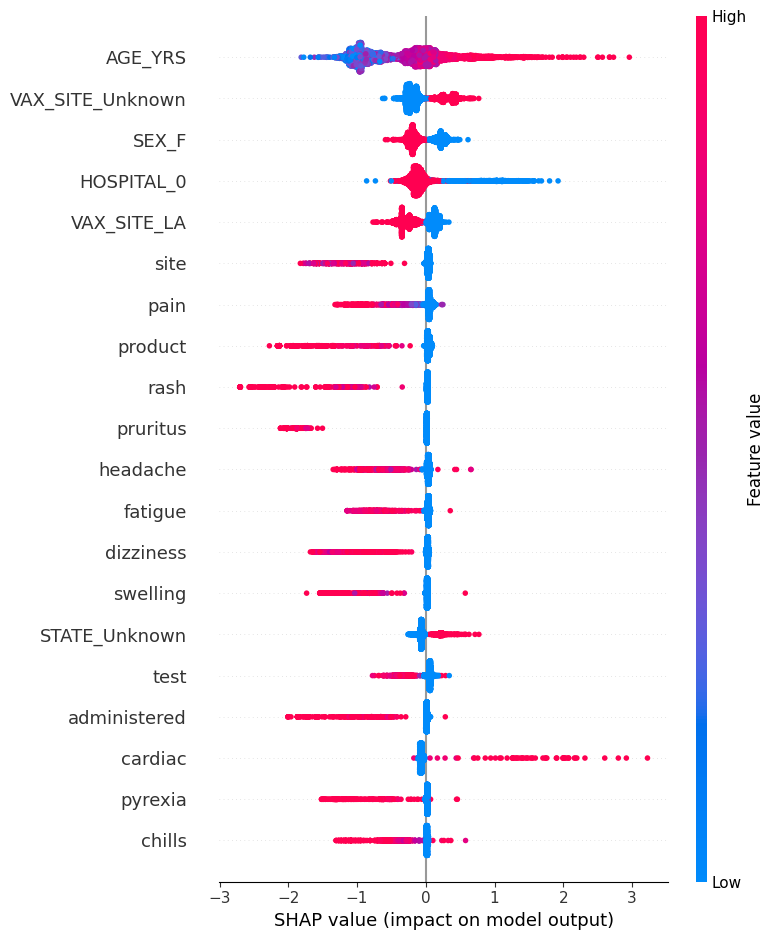

In [66]:
categorical_columns = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
numerical_columns = numerical_features
tfidf_allergies_columns = model_pipeline.named_steps['preprocessor'].named_transformers_['tfidf_allergies'].get_feature_names_out()
tfidf_history_columns = model_pipeline.named_steps['preprocessor'].named_transformers_['tfidf_history'].get_feature_names_out()
tfidf_curill_columns = model_pipeline.named_steps['preprocessor'].named_transformers_['tfidf_currill'].get_feature_names_out()
tfidf_symptoms_columns = model_pipeline.named_steps['preprocessor'].named_transformers_['tfidf_symptoms'].get_feature_names_out()
feature_names = np.concatenate([numerical_columns, categorical_columns, tfidf_allergies_columns, tfidf_history_columns, tfidf_curill_columns, tfidf_symptoms_columns])
X_processed = model_pipeline.named_steps['preprocessor'].transform(X)
sample_indices = np.random.choice(X_processed.shape[0], 5000, replace=False)
X_small = X_processed[sample_indices, :]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_small)
X_df = pd.DataFrame(X_small.toarray(), columns=feature_names)
shap.summary_plot(shap_values, X_df, feature_names=feature_names)


# 5.  Discussion/Conclusion

The goal was to determine if we could make a model that could leverage the data in an unbiased was for predicting if a person would die or not given their health history, symptoms, and vaccine information using the VAERS dataset.  This proved to be difficult because of the imbalance in the dataset for people that died vs. people who survived, less than 1% died from this dataset.

In addition, there was a lot of data cleaning needed.  There were duplicate entries that had to be accounted for and data leakage in the symptoms for indicating **death**.  We were able to catch these issues before model training by visualizing our data using TDIF for the text based entries and finding words like *death* leaked into the **SYMPTOMS** column.  We also were able to see where entries were duplicated using pandas to show duplicates.  
If we were to train a model without accounting for these issues, we would produce a model that would appear on the surface to have high accuracy, precision, recall, and F1-scores.  However, we did our best to remove the bias from our data and make it fair as possible to train on.  

We trained 3 different types of models, LogisticRegression, RandomForest, and XGBoostClassifier.  We accounted for class imbalance by using the *scale_pos_weight* hyperparameter tuning for XGBoostClassifier with a GridSearch operation. We picked appropriate values based on the ratio of imbalance in the dataset and found that a value of 5 produced the best model with respect to F1-score, precision, recall, and accuracy.  

We then were able to look at the feature importances of our model using both scikit-learns feature importance values and SHAPLY.  We saw that if a patient was admitted to the hospital and was of a certain age that they would more likely be associated with **DIED**.
We saw this both in our trained models and in our EDA using correlation heatmaps.  

In conclusion, this was a fun dataset to work with and helped create a meaningful model based on the COVID19 vaccines for determining the probability a patient with adverse reactions to a COVID19 vaccine would die or not based on their symptoms and personal health history.  The model has a lot of room for improvement, but gives us insight into some of the things that appear to matter most for patient with adverse reactions like if they have to go to the hospital and how old they are.  